In [ ]:
!pip install opencv-python

In [ ]:
!pip install opencv-python scikit-image

# Exercise 1: Harris Corner Detection

# Load an image and convert to grayscale

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('slimshady.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply the Harris Corner Detection method to detect corners.

In [ ]:
# Convert the gray image to float32 type
gray = np.float32(gray)

# Apply the Harris Corner Detection
dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

# Result is dilated for marking the corners, not necessary
dst = cv2.dilate(dst, None)

# Threshold for an optimal value, marking the detected corners on the original image
image[dst > 0.01 * dst.max()] = [0, 0, 255]  # Marking the corners in red


# Visualize the corners on the image and display the result.

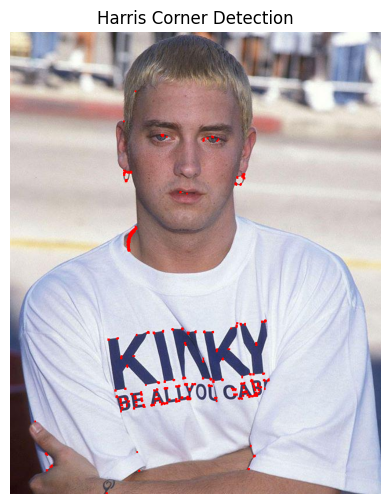

In [ ]:
# Convert the image from BGR to RGB (for displaying with Matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with detected corners
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.title('Harris Corner Detection')
plt.axis('off')
plt.show()

# Exercise 2: HOG (Histogram of Oriented Gradients) Feature Extraction

# Load an image of a person or any object and convert to grayscale

In [ ]:
from skimage.feature import hog
from skimage import exposure

image1 = cv2.imread('slimshady.jpg')

# Convert the image to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

# Apply the HOG descriptor to extract features.

In [ ]:
# Apply HOG descriptor
hog_features, hog_image = hog(
    gray1,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=True
)

# Normalize the HOG image for better visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Visualize the gradient orientations on the image.

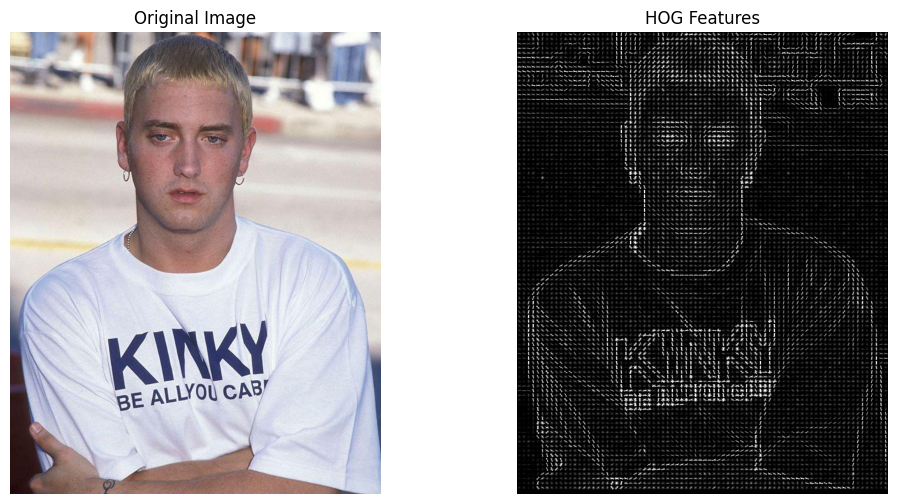

In [ ]:
# Display the original image and the HOG image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Original image
ax1.axis('off')
ax1.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')

# HOG image (shows gradient orientations)
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap='gray')
ax2.set_title('HOG Features')

plt.show()

# Exercise 3: FAST (Features from Accelerated Segment Test) Keypoint Detection

# Load an image and convert to grayscale

In [ ]:
image2 = cv2.imread('slimshady.jpg')

# Convert the image to grayscale
gray2 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

# Apply the FAST algorithm to detect keypoints

In [ ]:
# Create a FAST detector object
fast = cv2.FastFeatureDetector_create()

# Detect keypoints
keypoints = fast.detect(gray2, None)

# Visualize the keypoints on the image and display the result.

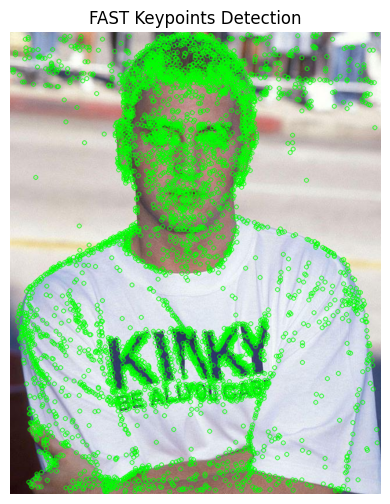

In [ ]:
# Draw the keypoints on the original image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the image with keypoints
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('FAST Keypoints Detection')
plt.axis('off')
plt.show()

# Exercise 4: Feature Matching using ORB and FLANN

# Load two images

In [ ]:
img = cv2.imread('building.jpg')
img1 = cv2.imread('building1.jpg')

gry = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gry1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

# Extract keypoints and descriptors using ORB.

In [ ]:
# Create an ORB detector object
orb = cv2.ORB_create()

# Detect keypoints and compute descriptors
keypoints, descriptors = orb.detectAndCompute(gry, None)
keypoints1, descriptors1 = orb.detectAndCompute(gry1, None)

# Match features between the two images using the FLANN matcher.

In [ ]:
# Define FLANN parameters
FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH,
                    table_number=6,  # 12
                    key_size=12,      # size of the hashed key
                    multi_probe_level=1)  # or 2
search_params = dict(checks=50)  # or pass empty for default

# Create a FLANN matcher object
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Match descriptors between the two images
matches = flann.knnMatch(descriptors, descriptors1, k=2)

In [ ]:
# Store good matches
good_matches = []
for match in matches:
    if len(match) == 2:  # Ensure there are two matches
        m, n = match
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

# Display the matched features.

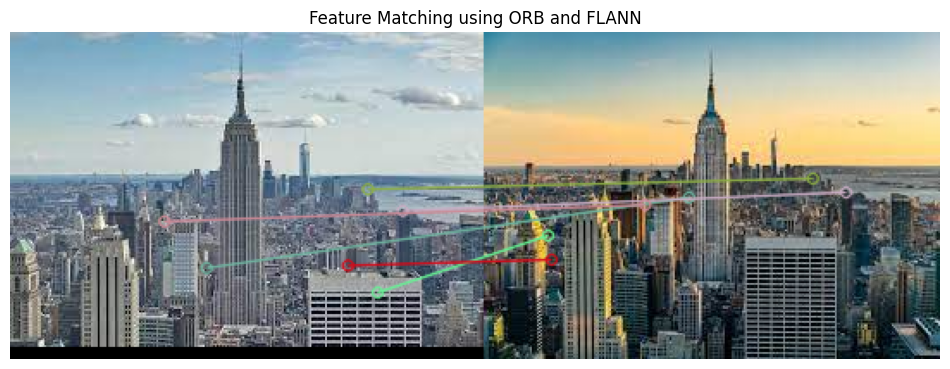

In [ ]:
# Draw matches
matched_image = cv2.drawMatches(img, keypoints, img1, keypoints1, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched features
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title('Feature Matching using ORB and FLANN')
plt.axis('off')
plt.show()

# Exercise 5: Image Segmentation using Watershed Algorithm

# Load an image

In [2]:
image3 = cv2.imread('slimshady.jpg')

# Convert the image to grayscale
gray3 = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)

# Apply a binary threshold to get a binary image
_, binary = cv2.threshold(gray3, 127, 255, cv2.THRESH_BINARY_INV)

# Apply the Watershed algorithm to segment the image into regions

In [3]:
# Perform morphological operations to clean up the binary image
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
unknown = cv2.subtract(sure_bg, np.uint8(sure_fg))

In [4]:
# Marker labeling
_, markers = cv2.connectedComponents(np.uint8(sure_fg))

# Add one to all the labels so that sure regions are marked with different values
markers = markers + 1

# Mark the unknown region with zero
markers[unknown == 255] = 0

# Apply the Watershed algorithm
cv2.watershed(image3, markers)

# Mark the boundaries with red color
image3[markers == -1] = [255, 0, 0]  # Red color for boundaries

# Visualize and display the segmented regions

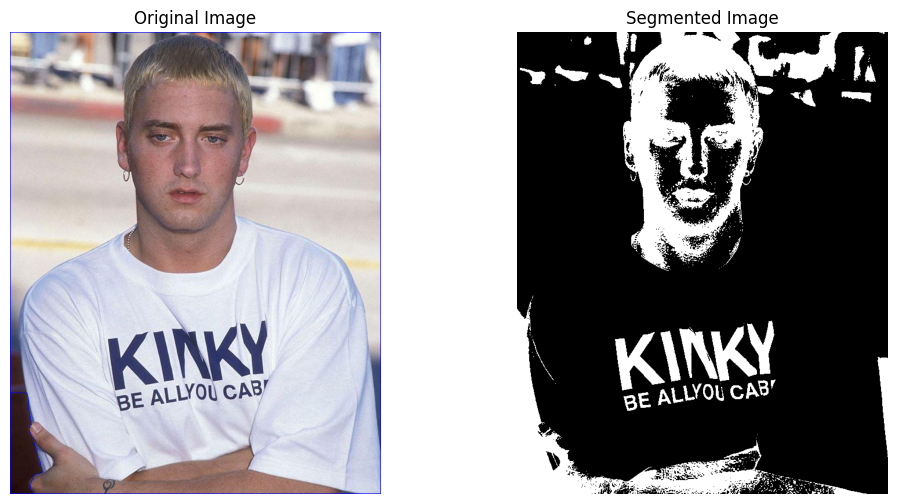

In [5]:
# Display the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')
plt.show()